In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from code.company_data_pipeline import *
from code.ticker_data_pipeline import *
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
s = get_series_list_from_files(limit=5000, min_mean_price_dollars=25)

In [3]:
len(s)

841

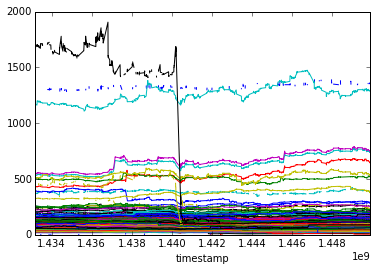

In [4]:
# Data! Horray!
df = pd.DataFrame(data=s).T
df.plot(legend=False)

In [5]:
# Deal with missing values
df = df.interpolate().fillna(method='bfill')

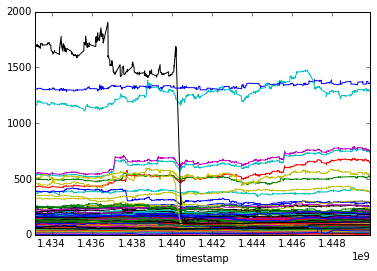

In [6]:
df.plot(legend=False)

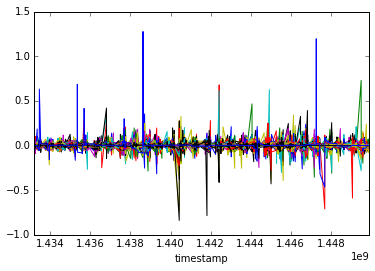

In [7]:
dif_df = df.pct_change().clip(-2, 2).fillna(0.)
dif_df.plot(legend=False)

In [105]:
variance_cutoff = dif_df.var().quantile(0.9)
c = dif_df.columns[dif_df.var() < variance_cutoff]
dif_df = dif_df[c]

In [106]:
# X[0] is now NAs because we diffed
X = dif_df.values[1:]
X

array([[  0.00000000e+00,  -3.77180575e-03,  -3.69088812e-03, ...,
         -6.21677629e-03,  -1.44812332e-02,  -9.89738738e-03],
       [  0.00000000e+00,  -1.18315192e-03,  -1.38921047e-03, ...,
          2.53853128e-03,  -6.27739786e-03,   1.39654539e-02],
       [  0.00000000e+00,  -4.73821369e-04,  -1.23657161e-03, ...,
          2.26080666e-03,   6.31705251e-03,   1.73976078e-02],
       ..., 
       [  6.45380435e-03,  -6.52680653e-03,   1.55577813e-03, ...,
         -1.08585002e-03,  -7.90190736e-03,  -2.25576956e-03],
       [  3.71245359e-03,   1.64242140e-03,   1.27053160e-03, ...,
         -4.75575786e-04,   9.15499405e-05,   6.26086957e-03],
       [  3.02622730e-03,  -5.62192551e-03,  -2.28792679e-03, ...,
         -9.65198477e-03,   4.76016111e-03,   2.41963360e-03]])

In [9]:
dif_df.columns

Index([u'aaap', u'aal', u'aapl', u'aaww', u'abax', u'abcb', u'abco', u'abcw',
       u'abmd', u'acad',
       ...
       u'yhoo', u'yy', u'z', u'zbra', u'zfgn', u'zg', u'zion', u'zltq',
       u'zsph', u'zvv'],
      dtype='object', length=841)

In [10]:
# Load data about the companies
with open(PROJECT_HOME + 'data/company/nasdaq_descriptions.tsv') as f:
    company_df = pd.read_csv(f, 
                         sep='\t', 
                         header=None)
company_df.columns = ['ticker', 'description']
company_df = company_df.dropna().set_index('ticker')

tv = TfidfVectorizer(stop_words='english')
tfidf = tv.fit_transform(company_df.description)
features = np.array(tv.get_feature_names())
# Change the 2d array to a list of 1d arrays
tfidf = map(lambda x: x.flatten(), np.vsplit(tfidf.toarray(), tfidf.shape[0]))
company_df['tfidf'] = tfidf
company_df.head()

,description,tfidf
ticker,,
aaap,We are an innovative radiopharmaceutical compa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aal,"American Airlines Group Inc. (AAG), a Delaware...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aame,"Atlantic American Corporation, a Georgia corpo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaoi,This report contains forward-looking statement...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
aaon,"AAON, Inc., a Nevada corporation, (""AAON Nevad...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
# Throw out comapanies where we don't have a good description
company_df = company_df[company_df.description.apply(lambda x: len(x) > 100)]

In [107]:
n_components=25
factorization = SparsePCA(n_components=n_components, alpha=0.03)
factorization.fit(X)

SparsePCA(U_init=None, V_init=None, alpha=0.03, max_iter=1000, method='lars',
     n_components=25, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [119]:
def analyze_principle_component(component, component_labels, company_df, vocab,
                                n_companies=15, n_words=20):
    '''
    component: 1d numpy array representing a linear combination of companies
    component_labels: the ticker symbols of the companies from component
    company_df: pandas dataframe with index ticker symbols, a column 'description' with a
                text description of the company and a column 'tfidf' a tfidf vector
    vocab: the vocab for the tfidf vector above
    
    returns: A dictionary with the following information about the company:
                'companies_pro': Numpy array of ticker symbols of the top n_companies
                                 companies associated with this component
                'importances_pro': Numpy array of floats that tell the weight of the
                                   above companies in the principle component
                'companies_con': Numpy array of ticker symbols of the top n_companies
                                 companies anti-correlated with this component
                'importances_con': Numpy array of floats that tell the weight of the
                                   above companies in the principle component 
                                   (these numbers are positive, measuring the anti-correlation)
                'words_pro':
                'word_importances_pro':
    '''
    d = {}
    idx_con = np.argsort(component)[:n_companies]
    d['companies_con'] = component_labels[idx_con]
    d['importances_con'] = component[idx_con] * -1.
    
    idx_pro = np.argsort(component)[::-1][:n_companies]
    d['companies_pro'] = component_labels[idx_pro]
    d['importances_pro'] = component[idx_pro]
    
    # TODO: Weight the word importances by the company importance
    #word_importances_list_con = company_df.ix[d['companies_con'], :]['tfidf']
    #print word_importances_list_con
    
    
    
    word_importances_con = company_df.ix[d['companies_con'], :]['tfidf'].mean()
    word_idx_con = word_importances_con.argsort()[::-1][:n_words]
    d['words_con'] = np.array(vocab)[word_idx_con]
    d['word_importances_con'] = word_importances_con[word_idx_con]
    
    word_importances_pro = company_df.ix[d['companies_pro'], :]['tfidf'].mean()
    word_idx_pro = word_importances_pro.argsort()[::-1][:n_words]
    d['words_pro'] = np.array(vocab)[word_idx_pro]
    d['word_importances_pro'] = word_importances_pro[word_idx_pro]
    
    return d
    
d = analyze_principle_component(factorization.components_[1], dif_df.columns.values,
                                 company_df, tv.get_feature_names())

In [22]:
def draw_importances_graph(names, importances, title, ax):
    n = len(names)
    #ax.figure()
    ax.set_title(title, fontdict={'fontsize': 10})
    ax.bar(range(n), importances,
           color="r", align="center")
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-1, n])
    labels = ax.get_xticks()
    ax.tick_params(labelsize=20)

In [74]:
def graph_component(d):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
    f.subplots_adjust(bottom=0.01)

    draw_importances_graph(d['companies_con'],
                           d['importances_con'], 
                           "Company Importances Con",
                           ax1)

    draw_importances_graph(d['words_con'],
                           d['word_importances_con'], 
                           "Word Importances Con",
                           ax2)

    draw_importances_graph(d['companies_pro'],
                           d['importances_pro'], 
                           "Company Importances Pro",
                           ax3)

    draw_importances_graph(d['words_pro'],
                           d['word_importances_pro'], 
                           "Word Importances Pro",
                           ax4)


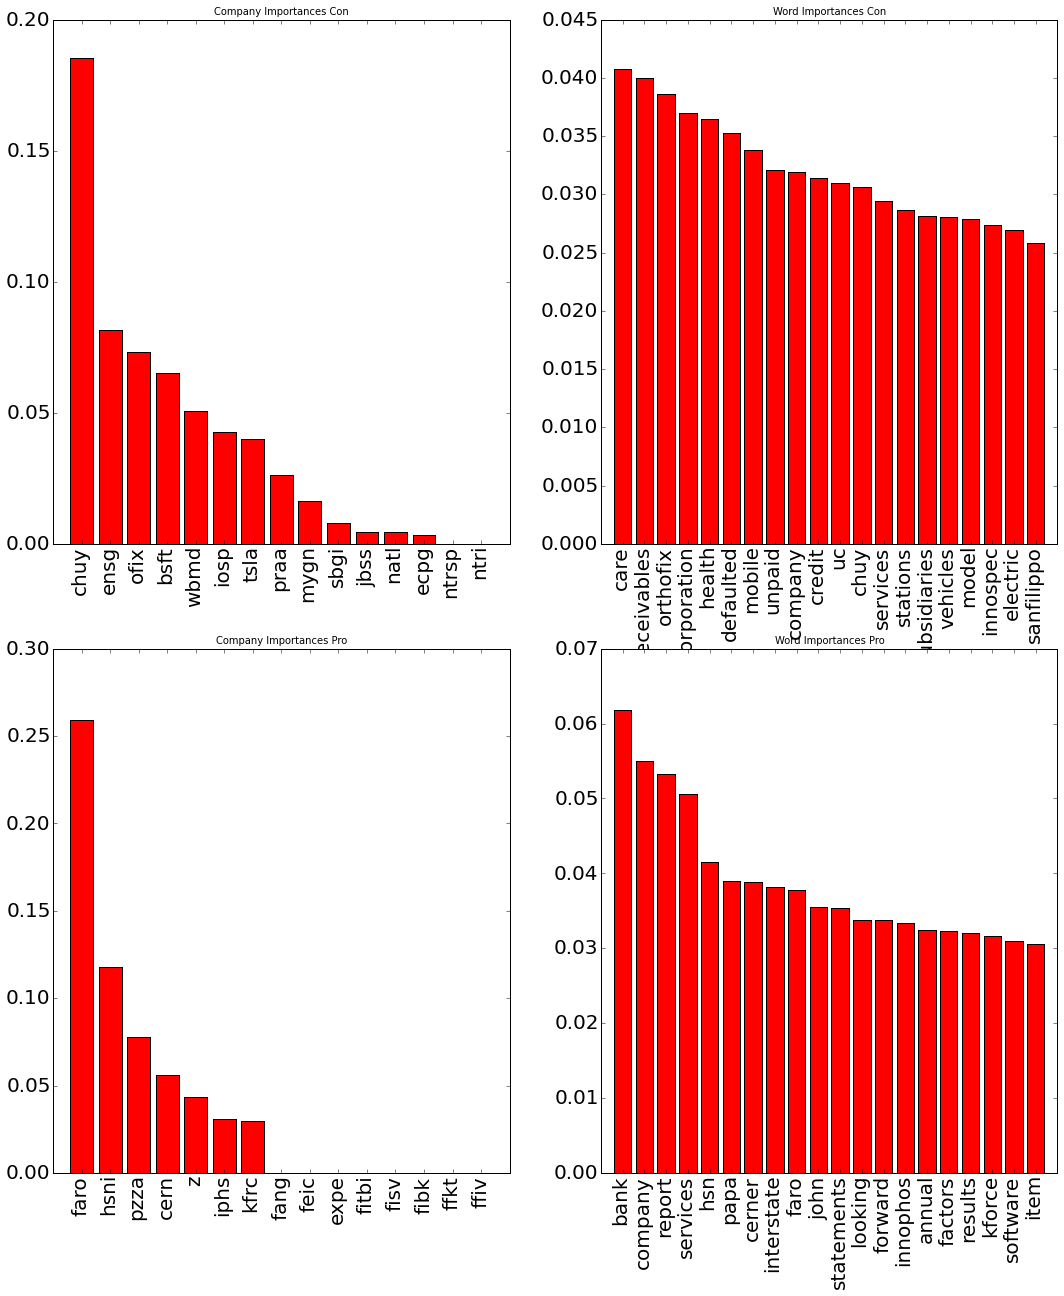

In [130]:
d = analyze_principle_component(factorization.components_[15], dif_df.columns.values,
                                 company_df, tv.get_feature_names())
graph_component(d)


In [17]:
# We can clean up the data and get better results by finding a way to dedupe the list of
# companies.  Some are subsidiaries of the others and track very closely.  These are then 
# overrepresented in the data.

In [18]:
# Biotech and pharma seems to be overrepresented in the data.  What is going on with 
# that.  

In [19]:
# We could try daily instead of hourly.  

In [ ]:
# TODO: Weight the tfidf average by company importance.  